In [1]:
import zipfile, py7zr
import numpy as np
import numpy.linalg as la
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm

This notebook matches the links of the Paris counting network with the links of a MATSim network:
- Load MATSim network
- Load [French zoning system (IRIS)](https://geoservices.ign.fr/contoursiris), to find all zones in Paris, to reduce MATSim network to the perimeter of Paris
- Load [counting network](https://opendata.paris.fr/explore/dataset/referentiel-comptages-routiers/information/)
- Perform matching by angle and centroid


## Configuration

In [2]:
# Path to the French zoning system
input_iris_path = "data/input/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01.7z"

# Path to the MATSim network file
input_matsim_path = "data/input/idf_network.shp"

# Path to the couting network file
input_reference_path = "data/input/referentiel-comptages-routiers.zip"

In [3]:
# Path to the CSV file giving the matching link IDs
output_matching_path = "data/output/matching.csv"

# Path to a file containing the MATSim network with matching information for visualization
output_matsim_path = "data/output/matsim.gpkg"

# Path to a file containing the counting network with matching information for visualization
output_reference_path = "data/output/reference.gpkg"

In [4]:
# Path to temp directory that is used to unpack the zoning system
temp_path = "data/temp"

In [5]:
# Configure matching process

# Trade-off between scoring angle difference and centroid distance
alpha = 0.1

# Before finding the best match, we filter out unlikely matches

# Maximum centroid distance between two candidates
maximum_distance = 50

# Maximum angle difference between two candidates
maximum_angle = 15 * np.pi / 180.0

## Load data

In [6]:
# Extract shape files
with py7zr.SevenZipFile(input_iris_path) as archive:
    archive.extractall(temp_path)

# Load zoning data
df_zones = gpd.read_file(
    "{}/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2022-06-00180/CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2022/CONTOURS-IRIS.shp".format(temp_path))

# Filter for Paris (75)
df_zones = df_zones[df_zones["INSEE_COM"].str.startswith("75")]

# Dissolve into one big shape
df_zones = df_zones.dissolve()[["geometry"]]

# Make sure we are on the same projection
df_zones = df_zones.to_crs("EPSG:2154")

<Axes: >

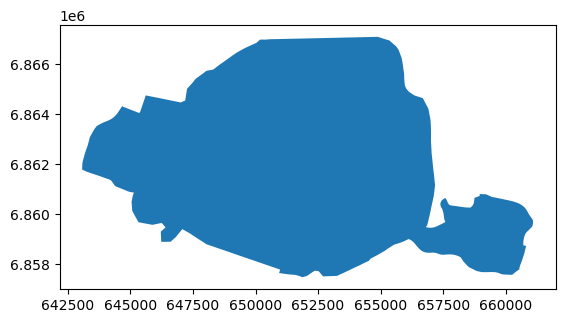

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_zones.plot(ax=ax)

In [8]:
# Extract reference network
with zipfile.ZipFile(input_reference_path) as archive: 
    archive.extractall(temp_path)

# Load reference network data
df_reference = gpd.read_file("{}/referentiel-comptages-routiers.shp".format(temp_path))

# Clean up network data
df_reference = df_reference.rename(columns = {
    "iu_ac": "reference_id"
})[["reference_id", "geometry"]]

# Make sure we are on the same projection
df_reference = df_reference.to_crs("EPSG:2154")

<Axes: >

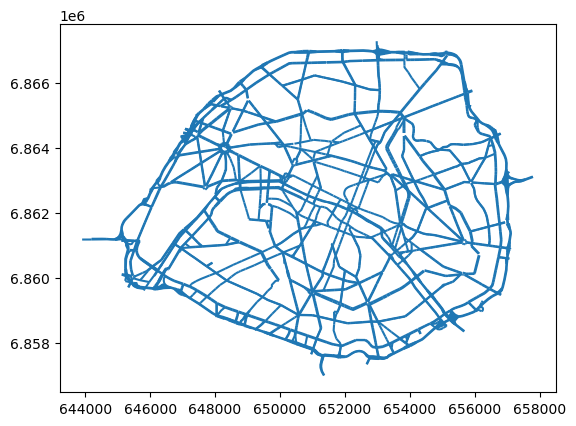

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_reference.plot(ax=ax)

In [10]:
len(df_reference['reference_id'].unique())

3348

In [11]:
# Load simulation link data
df_simulation = gpd.read_file(input_matsim_path)

df_simulation = df_simulation.rename(columns = {
    "link": "simulation_id"
})[["simulation_id", "geometry", "osm"]]

<Axes: >

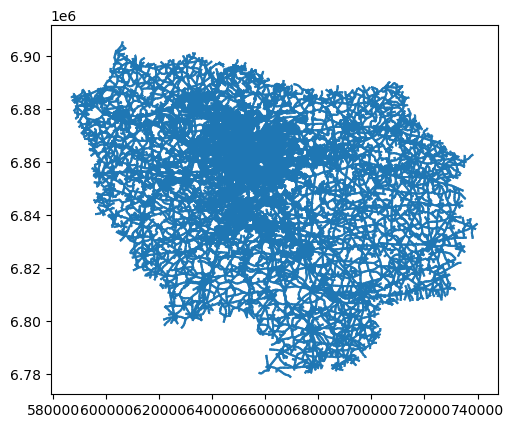

In [12]:
fig, ax = plt.subplots()
df_simulation.plot(ax=ax)

In [13]:
# Filter links for Paris
df_simulation = gpd.sjoin(df_simulation, df_zones, predicate = "within")

In [14]:
# Filter for higher order roads
df_simulation = df_simulation[
    df_simulation["osm"].str.contains("motorway") |
    df_simulation["osm"].str.contains("trunk") |
    df_simulation["osm"].str.contains("primary") |
    df_simulation["osm"].str.contains("secondary") |
    df_simulation["osm"].str.contains("tertiary")
]

<Axes: >

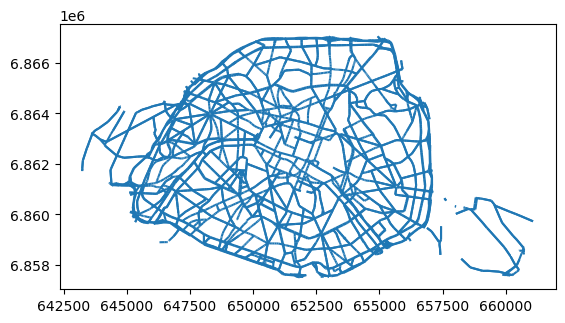

In [15]:
fig, ax = plt.subplots()
df_simulation.plot(ax=ax)

In [16]:
df_simulation

,simulation_id,geometry,osm,index_right
63,129032,"LINESTRING (658429.770 6860243.901, 658485.088...",tertiary,0
64,129031,"LINESTRING (658485.088 6860234.342, 658429.770...",tertiary,0
76,129012,"LINESTRING (658518.629 6860213.552, 658518.006...",tertiary,0
77,129011,"LINESTRING (658514.573 6860210.968, 658518.629...",tertiary,0
78,129010,"LINESTRING (658478.228 6860199.898, 658514.573...",tertiary,0
...,...,...,...,...
629335,96201,"LINESTRING (654611.674 6858588.269, 654625.096...",tertiary,0
629491,96348,"LINESTRING (649811.842 6864831.946, 649800.827...",secondary_link,0
629756,96647,"LINESTRING (655252.019 6860634.838, 655328.377...",tertiary,0
629757,96648,"LINESTRING (655328.377 6860537.586, 655252.019...",tertiary,0


## Matching

In [17]:
# Calculate centroids
reference_centroids = np.vstack([
    df_reference["geometry"].centroid.x, df_reference["geometry"].centroid.y]).T

simulation_centroids = np.vstack([
    df_simulation["geometry"].centroid.x, df_simulation["geometry"].centroid.y]).T

In [18]:
# Calculate orientation

def angle(geometry):
    coordinates = np.array(geometry.xy).T
    return np.arctan2(coordinates[-1, 1] - coordinates[0, 1], coordinates[-1, 0] - coordinates[0, 0])
    
reference_angles = df_reference["geometry"].apply(angle).values
simulation_angles = df_simulation["geometry"].apply(angle).values

In [19]:
len(simulation_angles)

11866

In [20]:
# Calculate n-to-m distances

centroid_distances = np.zeros((len(reference_centroids), len(simulation_centroids)))
angle_distances = np.zeros((len(reference_centroids), len(simulation_centroids)))


In [25]:
for k in tqdm(range(len(reference_centroids))):
    centroid_distances[k,:] = la.norm(reference_centroids[k] - simulation_centroids, axis = 1)
    angle_distances[k,:] = np.abs(reference_angles[k] - simulation_angles)

angle_distances[angle_distances < 0.0] += 2.0 * np.pi

  0%|          | 0/3739 [00:00<?, ?it/s]

In [26]:
# Prepare scoring / matching
scores = centroid_distances + alpha * angle_distances

# Deactivate improbable matchings
scores[centroid_distances > maximum_distance] = np.inf
scores[angle_distances > maximum_angle] = np.inf

In [27]:
# Matching process
matchings = []
matched_scores = []

# The idea is relatively simple:
# - Find the matching with the smallest score among those with a finite value
# - Note down the matching, and set all matching containing the two links to Inf
# - Continue until no scores with finite value are left

current = np.count_nonzero(~np.isfinite(scores))

with tqdm(total = np.prod(scores.shape) - current) as progress:
    while np.count_nonzero(np.isfinite(scores)) > 0:
        # Find best score and note down
        index = np.unravel_index(np.argmin(scores), scores.shape)
        matched_scores.append(scores[index])

        # Set both invlved links to Inf
        scores[index[0], :] = np.inf
        scores[:, index[1]] = np.inf
        
        # Manage progress plotting
        update = np.count_nonzero(~np.isfinite(scores))
        
        if update > current:
            progress.update(update - current)
            current = update

        matchings.append(index)
        
matchings = np.array(matchings) # The matchings themselves (index reference, index matsim)
matched_scores = np.array(matched_scores) # The scores of the matchings

  0%|          | 0/4918 [00:00<?, ?it/s]

In [30]:
len(matched_scores)

3052

## Output

In [31]:
# Construct a data set containing all matching information
df_matching = pd.DataFrame({
    "reference_id": df_reference.iloc[matchings[:,0]]["reference_id"].values,
    "simulation_id": df_simulation.iloc[matchings[:,1]]["simulation_id"].values,
    "osm": df_simulation.iloc[matchings[:,1]]["osm"].values,
    "score": matched_scores
})

df_matching.to_csv(output_matching_path, sep = ";", index = False)

In [32]:
df_matching

,reference_id,simulation_id,osm,score
0,5583,140676,secondary,0.236701
1,6462,2896,primary,0.336100
2,5484,63738,tertiary,0.388226
3,926,37424,primary,0.395453
4,1441,630247,primary,0.402470
...,...,...,...,...
3047,6276,531085,secondary,49.788027
3048,4664,137318,tertiary,49.814337
3049,4542,447368,primary,49.927416
3050,6877,181428,primary,49.967244


In [40]:
# Write comparison network files
if not output_reference_path is None:
    df_comparison = df_reference.copy()
    df_comparison = pd.merge(df_comparison, df_matching)
    df_comparison.to_file(output_reference_path)

In [41]:
df_comparison

,reference_id,geometry,simulation_id,osm,score
0,1724,"LINESTRING (653834.637 6866714.014, 653690.871...",237922,primary,6.091825
1,818,"LINESTRING (652979.286 6857838.589, 653163.336...",482643,primary,45.855744
2,4264,"LINESTRING (648727.007 6863754.857, 648833.278...",62910,primary,13.163259
3,4272,"LINESTRING (649043.528 6863622.236, 648838.372...",644278,primary,46.214960
4,460,"LINESTRING (654082.996 6860202.190, 653902.335...",637489,primary,14.225055
...,...,...,...,...,...
3778,1501,"LINESTRING (655685.902 6865555.152, 655722.382...",138634,primary,42.969583
3779,193,"LINESTRING (650869.168 6861809.546, 650816.422...",66095,tertiary,3.836108
3780,659,"LINESTRING (650807.060 6859642.322, 650886.949...",259106,secondary,0.633735
3781,4448,"LINESTRING (648336.545 6863619.866, 648316.150...",144825,primary,10.743882


In [42]:

if not output_matsim_path is None:
    df_comparison = df_simulation.copy()
    df_comparison = pd.merge(df_comparison, df_matching)
    df_comparison.to_file(output_matsim_path)

In [43]:
df_comparison

,simulation_id,geometry,osm,index_right,reference_id,score
0,132941,"LINESTRING (646872.051 6863836.594, 646847.072...",primary_link,0,5641,46.278804
1,128543,"LINESTRING (647665.321 6862084.906, 647741.348...",secondary,0,6390,19.422274
2,127988,"LINESTRING (647409.114 6861820.881, 647244.478...",primary,0,4524,3.223199
3,127414,"LINESTRING (650308.037 6858408.410, 650180.754...",primary,0,741,5.128629
4,127401,"LINESTRING (650182.170 6858436.010, 650256.736...",primary,0,724,17.002279
...,...,...,...,...,...,...
3047,93074,"LINESTRING (654362.490 6861791.983, 654369.548...",tertiary,0,4670,11.937146
3048,93207,"LINESTRING (649843.566 6860975.357, 649847.146...",primary,0,5786,5.679841
3049,93452,"LINESTRING (654892.788 6860439.637, 654978.125...",secondary,0,5800,16.638107
3050,93453,"LINESTRING (654978.125 6860378.249, 654892.788...",secondary,0,5801,14.372578
